### 通し課題1 Kickstar Ploject

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support
import datetime
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf

In [2]:
df_ks0 = pd.read_csv("kickstarter_project/ks-projects-201801.csv")
df_ks0.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


説明変数の相関係数を表示して除外する変数を決める。
除外する説明変数を本来なら機械側で計算して決めないといけないがとりあえず人側で決める。usd_pledged_realはstateを数値化したものなので除外。pledgedとusd pledged, goalとusd_goal_realはほぼ同じデータなので

In [3]:
#必要そうな列だけcsv読み込む
df_ks = pd.read_csv("kickstarter_project/ks-projects-201801.csv")[[ 'state', 'category', 'main_category', 'currency', 'country', 'usd pledged', 'usd_goal_real', 'deadline', 'launched']]

#KSのlaunched、deadlineから開催期間(日数)を計算する
#文字列をdatetime型に変換
#df_ks['launched'] = datetime.datetime.strptime(df_ks['launched'], '%Y/%m/%d %H:%M') 
#df_ks['deadline'] = datetime.datetime.strptime(df_ks['deadline'], '%Y/%m/%d')
df_ks['launched'] = pd.to_datetime(df_ks['launched']) 
df_ks['deadline'] = pd.to_datetime(df_ks['deadline'])

#期間を計算
df_ks['delta'] = (df_ks['deadline'] - df_ks['launched']).apply(lambda x: x.days)
#こっちだとエラー出た
#df_ks['delta'] = datetime.datetime.strptime(df_ks['launched'], '%d %H:%M:%S')
#.apply(~がないとerror起こす。配列には適用できない？
#print(df_ks['delta'].days)

#launch, deadline削除
df_ks = df_ks.drop(columns=['launched', 'deadline'])
#category削除
df_ks = df_ks.drop(columns=['category'])

#stateがsuccessfulとfailed以外のもの削除
df_ks = df_ks.query('state == ["successful", "failed"]')

#stateの列を数字に置き換え(failedを0、successfulを1)
for df in [df_ks]:    
    df.loc[df['state']=='failed', "state"]=0
    df.loc[df['state']=='successful', "state"]=1

print(df_ks.head())
#欠損値がないか確認
print(df_ks.isnull().sum())
print(df_ks.notnull().sum())

   state main_category currency country  usd pledged  usd_goal_real  delta
0      0    Publishing      GBP      GB          0.0        1533.95     58
1      0  Film & Video      USD      US        100.0       30000.00     59
2      0  Film & Video      USD      US        220.0       45000.00     44
3      0         Music      USD      US          1.0        5000.00     29
5      1          Food      USD      US      52375.0       50000.00     34
state              0
main_category      0
currency           0
country            0
usd pledged      210
usd_goal_real      0
delta              0
dtype: int64
state            331675
main_category    331675
currency         331675
country          331675
usd pledged      331465
usd_goal_real    331675
delta            331675
dtype: int64


In [4]:
#usd pledged の欠損値を埋める
df_ks['usd pledged'] = df_ks['usd pledged'].fillna("0")

In [5]:
#相関係数を見る
df_ks.corr().style.background_gradient(cmap="summer")

,state,usd_goal_real,delta
state,1,-0.0237352,-0.116437
usd_goal_real,-0.0237352,1,0.0216067
delta,-0.116437,0.0216067,1


main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater,All
state,,,,,,,,,,,,,,,,
0,14131,4036,5703,1235,14814,14182,32904,15969,16003,3137,21752,6384,23145,20616,3708,197719
1,11510,5842,2115,2338,10550,5593,23623,6085,12518,1012,24197,3305,12300,6434,6534,133956
All,25641,9878,7818,3573,25364,19775,56527,22054,28521,4149,45949,9689,35445,27050,10242,331675


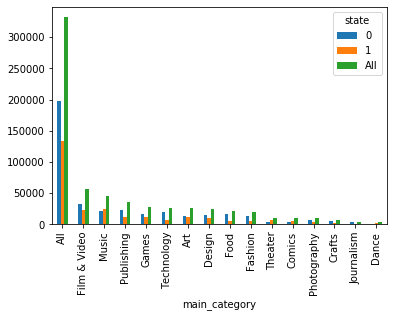

currency,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD,All
state,,,,,,,,,,,,,,,
0,4610,8238,465,567,10496,17395,261,16,1015,421,826,1001,276,152132,197719
1,2011,4137,187,362,3882,12081,216,7,396,163,448,509,178,109379,133956
All,6621,12375,652,929,14378,29476,477,23,1411,584,1274,1510,454,261511,331675


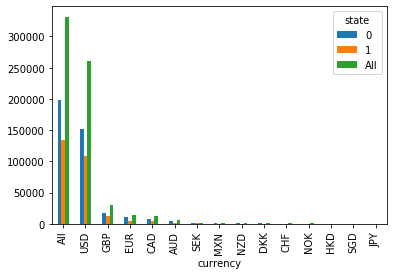

country,AT,AU,BE,CA,CH,DE,DK,ES,FR,GB,...,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US,All
state,,,,,,,,,,,,,,,,,,,,,
0,378,4606,371,8236,465,2499,566,1381,1612,17387,...,38,1015,105,1794,420,826,1000,276,152061,197719
1,107,2010,152,4134,187,937,360,492,908,12067,...,19,396,105,617,162,448,509,178,109299,133956
All,485,6616,523,12370,652,3436,926,1873,2520,29454,...,57,1411,210,2411,582,1274,1509,454,261360,331675


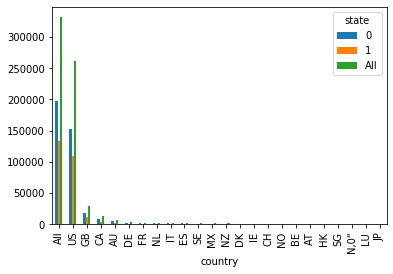

In [6]:
#質的変数のみの表示
for col in df_ks.columns:
    if col=="state"or col=="usd pledged"or col=="usd_goal_real"or col=="deadline"or col=="launched"or col=="delta":
        continue
    #クロス集計分析.カテゴリごとのstate集計
    df_cross = pd.crosstab(index=[df_ks["state"]], columns=df_ks[col],margins=True)
    display(df_cross)
    df_cross_show = df_cross.T.sort_values(by=['All'], ascending=False)
    df_cross_show.plot.bar()
    plt.show()

In [7]:
#質的変数をダミー変数へ
use_col = ["main_category","country", "currency"]

dum_ks = pd.get_dummies(df_ks[use_col]) 
display(dum_ks.head())
display(dum_ks.tail())
np.savetxt('ks-projects-201801.csv',dum_ks, delimiter=',')

# ダミー変数へ変換後のデータセットキーの確認
#print(dum_ks.keys())

,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
378654,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
378657,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378658,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378660,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
"""
# カテゴリごとの成功率
print(df_ks.groupby(["main_category"]).mean()["state"])
print(df_ks.groupby(["currency"]).mean()["state"])
df_ks.groupby(["country"]).mean()["state"]
"""
# ダミー変数へ変換後のデータフレームに更新
df_ks = pd.concat([df_ks, dum_ks], axis=1)
df_ks = df_ks.drop(columns=['main_category', 'country', 'currency'])
df_ks.head()

,state,usd pledged,usd_goal_real,delta,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,1533.95,58,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,100,30000.00,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,220,45000.00,44,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,5000.00,29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,52375,50000.00,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
# ダミー変数へ変換後のデータセットキーの確認
#print(df_ks.describe())
print(df_ks.keys())

Index(['state', 'usd pledged', 'usd_goal_real', 'delta', 'main_category_Art',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US',
       'currency_AUD', 'currency_CAD', 'currency_CHF', 'currency_DKK',
       'currency_EUR', 'currency_GBP', 'currency_HKD', 'currency_JPY',
       'currency_MXN', 

               state  usd_goal_real          delta  main_category_Art  \
count  331675.000000   3.316750e+05  331675.000000      331675.000000   
mean        0.403877   4.151000e+04      32.954902           0.077308   
std         0.490674   1.108930e+06      12.713329           0.267079   
min         0.000000   1.000000e-02       0.000000           0.000000   
25%         0.000000   2.000000e+03      29.000000           0.000000   
50%         0.000000   5.000000e+03      29.000000           0.000000   
75%         1.000000   1.500000e+04      35.000000           0.000000   
max         1.000000   1.663614e+08      91.000000           1.000000   

       main_category_Comics  main_category_Crafts  main_category_Dance  \
count         331675.000000         331675.000000        331675.000000   
mean               0.029782              0.023571             0.010773   
std                0.169986              0.151709             0.103231   
min                0.000000              0.000

In [12]:
#ロジスティック回帰
y = df_ks["state"].values
#X = df_ks[["usd pledged","usd_goal_real", "delta"]].values
X = df_ks.drop("state", axis=1)
clf = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))


w0 = 565.354, w1 = 10792.112, w2 = -4987.996


In [13]:
# ラベルを予測
y_pred = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_pred)))

対数尤度 = -2.742
正答率 = 92.060%


In [14]:
# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「state=1」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 92.060%
適合率（Precision） = 90.842%
再現率（Recall） = 96.399%
F1値（F1-score） = 93.538%


In [15]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,190599,7120
正解 = successful,19215,114741
